This code is used to capture images of cans or bottles, and perform the following:
- Rotation
- White balance
- Masking
- Bounding Box Annotation

In [45]:
# Capture images from the USB camera and save them to the img directory

import cv2
import numpy as np
import time
import os
from datetime import datetime
from matplotlib import pyplot as plt

base_dir = '/home/shibley/development/bevnet'

# cd into base_dir directory
os.chdir(base_dir)

# Create the img directory if it doesn't exist
if not os.path.exists('img'):
    os.makedirs('img')

# Define some kernels for morphological operations
kernel_sml = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(10,10))
kernel_med = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(40,40))
kernel_lrg = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(80,80))
kernel_hug = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(120,120))
kernel_tall = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,25))

# White balance function from:
# https://stackoverflow.com/questions/46390779/automatic-white-balancing-with-grayworld-assumption
def white_balance(img):
    result = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    avg_a = np.average(result[:, :, 1])
    avg_b = np.average(result[:, :, 2])
    result[:, :, 1] = result[:, :, 1] - ((avg_a - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result[:, :, 2] = result[:, :, 2] - ((avg_b - 128) * (result[:, :, 0] / 255.0) * 1.1)
    result = cv2.cvtColor(result, cv2.COLOR_LAB2BGR)
    return result

# Get inputs from user:
bev_type = input("Enter beverage type (can or bottle): ")
bev_type = bev_type.lower()
if bev_type not in ("can", "bottle"):
    print("Invalid input. Please enter 'can' or 'bottle'.")
    exit()

crop_type = input("Enter the type of crop to perform (contour or box): ")
crop_type = crop_type.lower()
if crop_type not in ("contour", "box"):
    print("Invalid input. Please enter 'contour' or 'box'.")
    exit()

num_imgs = input("Enter the number of images to capture (1-50): ")
if not num_imgs.isdigit():
    print("Invalid input. Please enter a number.")
    exit()
num_imgs = int(num_imgs)

cam_index = input("Enter the USB camera index (# in /dev/video#): ")
if not cam_index.isdigit():
    print("Invalid input. Please enter a number.")
    exit()
cam_index = int(cam_index)

bg_color = input("Enter the background color (black or white): ")
bg_color = bg_color.lower()
if bg_color not in ("black", "white"):
    print("Invalid input. Please enter 'black' or 'white'.")
    exit()

HP 5MP Camera: HP 5MP Camera (usb-0000:00:14.0-1):
	/dev/video0
	/dev/video1
	/dev/video2
	/dev/video3
	/dev/media0
	/dev/media1

HD Pro Webcam C920 (usb-0000:00:14.0-2.2.4.4):
	/dev/video5
	/dev/video6
	/dev/media2

Frames captured: 16


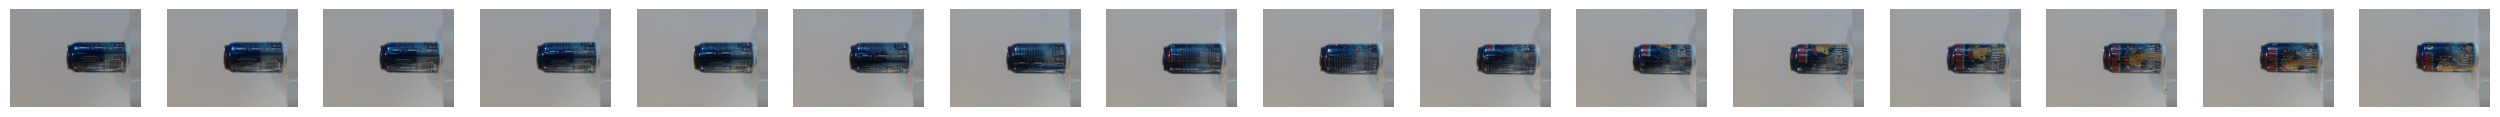

In [46]:

# print list of v4l2 devices
!v4l2-ctl --list-devices

# Release if the camera is already in use
#cap = cv2.VideoCapture(5)
#cap.release()
    
timestamp = datetime.now()

# Open the USB camera
cap = cv2.VideoCapture(cam_index) # index of USB camera in `v4l2-ctl --list-devices` (/dev/video#)
cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 720)
cap.set(cv2.CAP_PROP_FRAME_WIDTH, 960)
cap.set(cv2.CAP_PROP_FPS, 5)
cap.set(cv2.CAP_PROP_FOCUS, 25) # Manual focus
#cap.set(cv2.CAP_PROP_ZOOM, 120) # Optionally zoom

frames = []
# Capture images every 1 second for num_imgs seconds
for i in range(num_imgs):
    ret, frame = cap.read()
    frames.append(frame)
    # Sleep for 1 second
    time.sleep(1)

# Release the USB camera
cap.release()

print('Frames captured: ' + str(len(frames)))

# Display the images
fig, ax = plt.subplots(1,num_imgs,figsize=(2*num_imgs, 3))
for i, frame in enumerate(frames):
    ax[i].imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
    ax[i].axis('off')
plt.show()


In [47]:
imgs = []
for i, frame in enumerate(frames):
    # Rotate & whitebalance
    img = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE) 
    img = white_balance(img)
    imgs.append(img)
    # Save image
    cv2.imwrite('img/full/' + bev_type + '/' + str(timestamp) + "_" + str(i) + '.jpg', img)

In [48]:
# Crop & annotate images
print_imgs = []
for i, img in enumerate(imgs):
    # Create grayscale by choosing max of all channels
    img_gray = img.max(axis=2)
    # Blur and threshold
    img_blur = cv2.GaussianBlur(img_gray,(15,15),2)
    thresh = max(img_blur[10,10],img_blur[10,-10],img_blur[-10,10],img_blur[-10,-10])
    print("Threshold: " + str(thresh))
    ret,mask = cv2.threshold(img_blur,thresh,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    # Invert mask if background is white
    if bg_color == "white":
        mask = cv2.bitwise_not(mask)
    # Close and open the mask
    mask1 = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel_hug)
    mask2 = cv2.morphologyEx(mask1, cv2.MORPH_OPEN, kernel_med)
    if crop_type == "contour":
        # Apply mask to image
        mask3=cv2.cvtColor(mask2,cv2.COLOR_GRAY2BGR)#change mask to a 3 channel image 
        img=cv2.subtract(mask3,img)
        img=cv2.subtract(mask3,img)
    # Find bounding rectangle
    contours,hierarchy = cv2.findContours(mask2,cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    x,y,w,h = cv2.boundingRect(mask2)
    # Write csv file with bev_type & bounding box coordinates
    with open('img/annotations/' + bev_type + '/' + str(timestamp) + "_" + str(i) + '.csv', 'w') as f:
        f.write(bev_type + ',' + str(x) + ',' + str(y) + ',' + str(x+w) + ',' + str(y+h))
    # Crop image
    img_crop = img[y:y+h,x:x+w]
    cv2.imwrite('img/crop/' + bev_type + '/' + str(timestamp) + "_" + str(i) + '.jpg', img_crop)
    cv2.imwrite('img/mask/' + bev_type + '/' + str(timestamp) + "_" + str(i) + '_first' + '.jpg', mask)
    cv2.imwrite('img/mask/' + bev_type + '/' + str(timestamp) + "_" + str(i) + '_last' + '.jpg', mask2)
    if i == 7:
        print_imgs.append(img)
        print_imgs.append(mask)
        print_imgs.append(mask1)
        print_imgs.append(mask2)
        print_imgs.append(img_crop)

Threshold: 153
Threshold: 158
Threshold: 158
Threshold: 157
Threshold: 160
Threshold: 160
Threshold: 160
Threshold: 160
Threshold: 161
Threshold: 162
Threshold: 162
Threshold: 161
Threshold: 160
Threshold: 161
Threshold: 161
Threshold: 161


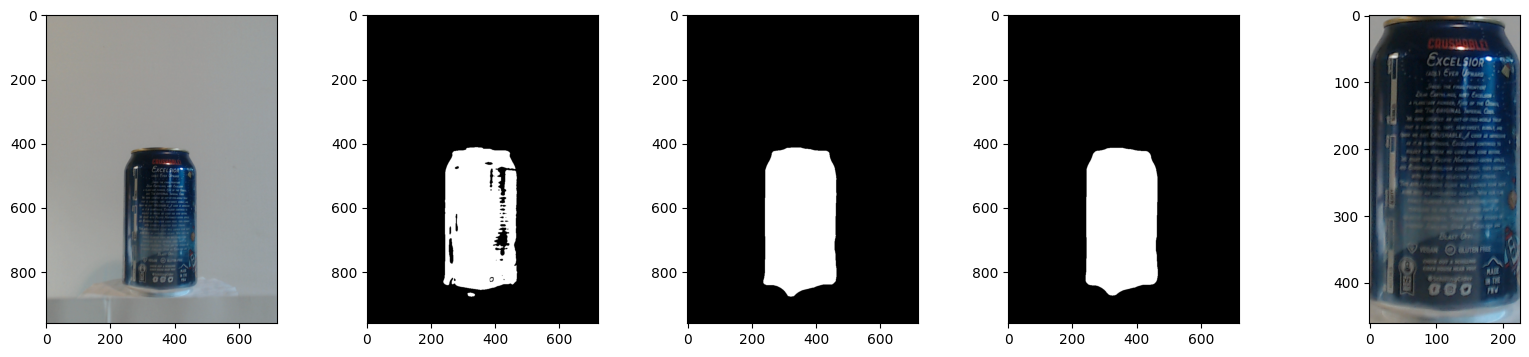

In [49]:
# Plot image processing steps
fig, ax = plt.subplots(1,len(print_imgs),figsize=(20, 4))
for i, img in enumerate(print_imgs):
    ax[i].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB),vmin=0,vmax=255)
plt.show()